In [78]:
import os 
import pandas as pd
import glob 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import pybedtools as pbt 
pbt.set_tempdir('/mnt/hpcscratch/jreyna/')
pbt.set_bedtools_path('/mnt/BioApps/bedtools/bin/')

os.chdir('/mnt/bioadhoc-temp/Groups/vd-ay/jreyna-temp/projects/dchallenge/')

#outdir = 'results/notebooks/colocalization_with_eqtl_catalogue/'
outdir = 'results/main/coloc/summary/'
os.makedirs(outdir, exist_ok=True)

In [2]:
import pycircos
import collections
import matplotlib.pyplot as plt
import wget

In [3]:
# load gwas meta-data
gwas_samplesheet = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')
gwas_samplesheet.set_index('gwas_id', inplace=True)
gwas_samplesheet.index = gwas_samplesheet.index.str.replace('#', '')

## Loading the GENCODE Reference

In [4]:
# gencode = pd.read_table('results/refs/gencode/v30/gencode.v30.annotation.bed', header=None)
# gencode = gencode.iloc[:, [5,6]]
# gencode.set_index(6, inplace=True)
# gencode = gencode.squeeze()
# gencode = gencode.to_dict()

# Load the gene data
gene_ref = 'results/refs/gencode/v30/gencode.v30.annotation.grch37.bed'
cols = ['chrom', 'start', 'end', 'strand', 'type', 'geneid', 'genename', 'detailed-type']
gencode = pd.read_table(gene_ref, header=None, names=cols)

# extract just the genes
genes_df = gencode.copy() #loc[gencode.type.isin(['gene'])]
genes_df = genes_df.loc[~genes_df.duplicated(subset='geneid'), :]
genes_df.loc[:, 'chrom'] = genes_df['chrom'].astype(str)
genes_df.set_index('geneid', inplace=True)

rev_gencode = {idx:sr.genename for idx, sr in genes_df.iterrows()}

## Loading and Processing the Colocalization Data 

In [5]:
major_cells = ['B-cell_naive', 'CD4_T-cell_naive',
               'CD8_T-cell_naive', 'NK-cell_naive','monocyte_naive']
major_gwas = ['T1D_32005708', 'T1D_34594039_GCST90018925', 'T1D_34012112_Gaulton'] #, 'T1D_25751624']

In [6]:
data = []
eqtl_cat_glob = 'results/main/coloc/Results/eQTL_Catalogue/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
eqtl_cat_glob = glob.glob(eqtl_cat_glob)
immunexut_glob = 'results/main/coloc/Results/ImmuNexUT/*/*/*/FINAL_Summary_Coloc_Gene_SNP_Pairs.bed'
immunexut_glob = glob.glob(immunexut_glob)
coloc_fns = sorted(eqtl_cat_glob + immunexut_glob) 
coloc_fns = [x for x in coloc_fns if 'test' not in x]
print('Number of colocalizations analyses: {}.'.format(len(coloc_fns)))

Number of colocalizations analyses: 170.


In [7]:
for fn in coloc_fns:
    
    # load the data
    df = pd.read_table(fn)
    
    # get GWAS, eQTL and gene expression sources
    fname_segs = fn.split('/')
    gwas = fname_segs[5]
    eqtl = fname_segs[6]
    ge = fname_segs[7]
    
    if gwas not in major_gwas:
        print('skipped gwas: {}'.format(gwas))
        continue 
        
    #     if ge not in major_cells:
    #         print('skipped ge:', ge)
    #         continue 

    #print('Processing: {}'.format(fn))
        
    # assign the current values
    df['gwas'] = gwas
    df['eqtl'] = eqtl
    df['ge'] = ge
    data.append(df)
    
t1d_data = pd.concat(data)

skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
skipped gwas: T1D_25751624
s

In [8]:
# add the gene name
t1d_data.geneName = t1d_data.geneName.str.replace('\.[0-9]*$', '', )
t1d_data['genename'] = t1d_data.geneName.replace(rev_gencode)

/tmp/ipykernel_14973/2572423673.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  t1d_data.geneName = t1d_data.geneName.str.replace('\.[0-9]*$', '', )


In [9]:
# removing duplicate SNP-gene pairs by find the one with the largest PP4
t1d_data_rgs = t1d_data.groupby(['gwas', 'eqtl', 'ge', 'rs_id', 'geneName'])
new_t1d_data = []
for grp, grp_df in t1d_data_rgs:
    max_index = np.argmax(grp_df.pp_H4_Coloc_Summary)
    new_t1d = grp_df.iloc[max_index,:]
    new_t1d_data.append(new_t1d)
new_t1d_data = pd.DataFrame(new_t1d_data)
new_t1d_data.reset_index(drop=True, inplace=True)

# assigning t1d_data to the new dataset
t1d_data = new_t1d_data.copy()

In [10]:
# creating a list of the most important columns 
major_cols = ['chr', 'pos','rs_id', 'variant_id', 'genename',
              'pp_H4_Coloc_Summary', 'dist', 'pvalue', 'FDR',
              'slope_snp', 'slope_se_snp', 'slope_gwas', 'slope_se_gwas',
              'pval_nominal', 'gwas', 'eqtl', 'ge', 'geneName']

# generating a dataframe the the most important columns
t1d_data = t1d_data[major_cols]

# renaming these columns for easier understanding
major_renames = {
    'chr': 'chr',
    'pos': 'pos',
    'rs_id': 'rsid',
    'variant_id': 'varid',
    'genename': 'genename', 
    'pp_H4_Coloc_Summary': 'ppH4',
    'dist': 'sg_dist',
    'pvalue': 'eqtl_pval',
    'FDR': 'eqtl_fdr',
    'slope_snp': 'eqtl_slope',
    'slope_se_snp': 'eqtl_slope_se',
    'slope_gwas': 'gwas_slope',
    'slope_se_gwas': 'gwas_slope_se',
    'pval_nominal': 'gwas_pval',
    'SampleSize': 'gwas_sample_size',
    'gwas': 'gwas_source',
    'eqtl': 'eqtl_source',
    'ge': 'ge_source',
    'geneName': 'gene_id'}
major_cols = [major_renames[x] for x in major_cols]
t1d_data.rename(columns=major_renames, inplace=True)

In [11]:
# add gene metedata including coordinates
t1d_data = t1d_data.merge(genes_df.drop('genename', axis=1),
                           left_on='gene_id', right_on='geneid',
                           how='left', indicator=True)

In [12]:
t1d_data

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
0,chr12,56007301,rs10876864,12:56007301:G:A,RPS26,0.775147,34050,7.580770e-87,1.004889e-81,-1.290540,0.000088,-0.243900,0.023800,1.423000e-24,T1D_32005708,BLUEPRINT,monocyte,ENSG00000197728,chr12,56435135.0,56438481.0,+,gene,protein_coding,both
1,chr12,56007301,rs10876864,12:56007301:G:A,RPS26,0.827108,34050,5.029280e-40,1.461887e-36,-0.283873,0.009782,-0.243900,0.023800,1.423000e-24,T1D_32005708,BLUEPRINT,neutrophil,ENSG00000197728,chr12,56435135.0,56438481.0,+,gene,protein_coding,both
2,chr10,6068912,rs7090530,10:6068912:C:A,RBM17,0.921262,20122,1.987100e-02,4.776097e-01,0.267105,0.012218,0.185500,0.024500,4.026000e-14,T1D_32005708,Bossini-Castillo_2019,Treg_naive,ENSG00000134453,chr10,6130997.0,6159420.0,+,gene,protein_coding,both
3,chr6,25414309,rs9366622,6:25414309:T:C,BTN3A2,0.861137,950850,1.114580e-04,1.660355e-02,0.583591,0.006620,-0.253600,0.032300,4.150000e-15,T1D_32005708,Bossini-Castillo_2019,Treg_naive,ENSG00000186470,chr6,26365387.0,26378548.0,+,gene,protein_coding,both
4,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.776392,794,6.510880e-59,7.558703e-54,-0.775832,0.000956,-0.246100,0.023800,4.242000e-25,T1D_32005708,GENCORD,LCL,ENSG00000197728,chr12,56435135.0,56438481.0,+,gene,protein_coding,both
5,chr10,6056861,rs706779,10:6056861:T:C,PRKCQ,0.848088,523440,3.192380e-02,6.418690e-01,-0.224932,0.015609,-0.166800,0.023800,2.250000e-12,T1D_32005708,GENCORD,LCL,ENSG00000065675,chr10,6469105.0,6622263.0,-,gene,protein_coding,both
6,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.757691,794,8.564040e-77,1.641986e-70,-1.307650,0.000075,-0.246100,0.023800,4.242000e-25,T1D_32005708,GENCORD,T-cell,ENSG00000197728,chr12,56435135.0,56438481.0,+,gene,protein_coding,both
7,chr10,6056986,rs706778,10:6056986:C:T,LINC02561,0.819732,785750,3.540220e-02,6.856415e-01,-0.226673,0.015146,0.167000,0.023800,2.105000e-12,T1D_32005708,GENCORD,T-cell,ENSG00000224034,chr10,5307996.0,5313199.0,-,gene,lincRNA,both
8,chr10,6056861,rs706779,10:6056861:T:C,ASB13,0.843532,390266,6.698020e-02,8.184685e-01,-0.287693,0.009385,-0.166800,0.023800,2.250000e-12,T1D_32005708,GTEx,LCL,ENSG00000196372,chr10,5680830.0,5708558.0,-,gene,protein_coding,both
9,chr12,56042145,rs1131017,12:56042145:C:G,RPS26,0.811863,794,7.539740e-196,3.429728e-190,-1.384650,0.000023,-0.246100,0.023800,4.242000e-25,T1D_32005708,GTEx,blood,ENSG00000197728,chr12,56435135.0,56438481.0,+,gene,protein_coding,both


### Save a unique list of SNPs within an SGL

In [13]:
gwas_grps = t1d_data.groupby('gwas_source')
for gwas_source, gwas_df in gwas_grps:
    
    print(gwas_source)
    
    gwas_df['sid'] = gwas_df['chr'] + '-' + gwas_df['pos'].astype(str)   
    uniq_sids = gwas_df['sid'].drop_duplicates().sort_values()
    uniq_sids = uniq_sids.str.replace(':', '-')
    
    fn = os.path.join(outdir, 'coloc_sgls.{}.tsv'.format(gwas_source))
    uniq_sids.to_csv(fn, header=False, index=False)

T1D_32005708
T1D_34012112_Gaulton
T1D_34594039_GCST90018925


### Checking Colocalized SNPs with Significant eQTLs (FDR<0.05)

In [14]:
sig_eqtls = t1d_data[major_cols].\
                        sort_values(['gwas_source', 'eqtl_source', 'ge_source', 'rsid']).\
                        set_index(['gwas_source', 'ge_source', 'rsid'])
sig_eqtls = sig_eqtls[sig_eqtls.eqtl_fdr < 0.05]

In [15]:
sig_eqtls.head()

chr       pos            varid genename  \
gwas_source  ge_source  rsid                                                    
T1D_32005708 monocyte   rs10876864  chr12  56007301  12:56007301:G:A    RPS26   
             neutrophil rs10876864  chr12  56007301  12:56007301:G:A    RPS26   
             Treg_naive rs9366622    chr6  25414309   6:25414309:T:C   BTN3A2   
             LCL        rs1131017   chr12  56042145  12:56042145:C:G    RPS26   
             T-cell     rs1131017   chr12  56042145  12:56042145:C:G    RPS26   

                                        ppH4  sg_dist     eqtl_pval  \
gwas_source  ge_source  rsid                                          
T1D_32005708 monocyte   rs10876864  0.775147    34050  7.580770e-87   
             neutrophil rs10876864  0.827108    34050  5.029280e-40   
             Treg_naive rs9366622   0.861137   950850  1.114580e-04   
             LCL        rs1131017   0.776392      794  6.510880e-59   
             T-cell     rs1131017   0.757691      794  8.564040e-77   

                                        eqtl_fdr  eqtl_slope  eqtl_slope_se  \
gwas_source  ge_source  rsid                                                  
T1D_32005708 monocyte   rs10876864  1.004889e-81   -1.290540       0.000088   
             neutrophil rs10876864  1.461887e-36   -0.283873       0.009782   
             Treg_naive rs9366622   1.660355e-02    0.583591       0.006620   
             LCL        rs1131017   7.558703e-54   -0.775832       0.000956   
             T-cell     rs1131017   1.641986e-70   -1.307650       0.000075   

                                    gwas_slope  gwas_slope_se     gwas_pval  \
gwas_source  ge_source  rsid                                                  
T1D_32005708 monocyte   rs10876864     -0.2439         0.0238  1.423000e-24   
             neutrophil rs10876864     -0.2439         0.0238  1.423000e-24   
             Treg_naive rs9366622      -0.2536         0.0323  4.150000e-15   
             LCL        rs1131017      -0.2461         0.0238  4.242000e-25   
             T-cell     rs1131017      -0.2461         0.0238  4.242000e-25   

                                              eqtl_source          gene_id  
gwas_source  ge_source  rsid                                                
T1D_32005708 monocyte   rs10876864              BLUEPRINT  ENSG00000197728  
             neutrophil rs10876864              BLUEPRINT  ENSG00000197728  
             Treg_naive rs9366622   Bossini-Castillo_2019  ENSG00000186470  
             LCL        rs1131017                 GENCORD  ENSG00000197728  
             T-cell     rs1131017                 GENCORD  ENSG00000197728

## Checking the Sources of Colocalized Datasets

In [16]:
check_sources = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source'])
check_sources = check_sources[['gwas_source', 'eqtl_source', 'ge_source']]

In [17]:
pd.set_option('display.max_rows', 100) 
display(check_sources.set_index(['gwas_source', 'eqtl_source']))
pd.set_option('display.max_rows', 20) 

ge_source
gwas_source               eqtl_source                               
T1D_32005708              BLUEPRINT                         monocyte
                          BLUEPRINT                       neutrophil
                          Bossini-Castillo_2019           Treg_naive
                          GENCORD                                LCL
                          GENCORD                             T-cell
...                                                              ...
T1D_34594039_GCST90018925 Schmiedel_2018                  Tfh_memory
                          Schmiedel_2018                 Th17_memory
                          Schmiedel_2018                  Th1_memory
                          Schmiedel_2018                  Th2_memory
                          Schmiedel_2018         monocyte_CD16_naive

[116 rows x 1 columns]

## Plotting the Number of SNP-Gene Pairs per Colocalization Analysis

In [18]:
study_summary = t1d_data.\
            value_counts(['gwas_source', 'eqtl_source', 'ge_source']).to_frame().reset_index().\
            sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
study_summary.rename(columns={0:'count'}, inplace=True)

In [19]:
print('The median number of colocalizations per study is {}.'.format(study_summary['count'].median()))

The median number of colocalizations per study is 2.0.


In [20]:
study_summary.sort_values('count', ascending=False)

,gwas_source,eqtl_source,ge_source,count
0,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,7
1,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,7
2,T1D_34012112_Gaulton,Schmiedel_2018,Treg_naive,5
3,T1D_32005708,ImmuNexUT,DN_B,4
4,T1D_32005708,ImmuNexUT,Naive_B,4
...,...,...,...,...
111,T1D_32005708,Schmiedel_2018,monocyte_CD16_naive,1
112,T1D_32005708,BLUEPRINT,neutrophil,1
113,T1D_34012112_Gaulton,ImmuNexUT,mDC,1
114,T1D_34012112_Gaulton,Quach_2016,monocyte_Pam3CSK4,1


In [21]:
eqtl_colors = study_summary.eqtl_source.unique()
eqtl_colors = {k:v for k,v in zip(eqtl_colors, sns.color_palette(n_colors=len(eqtl_colors)))}

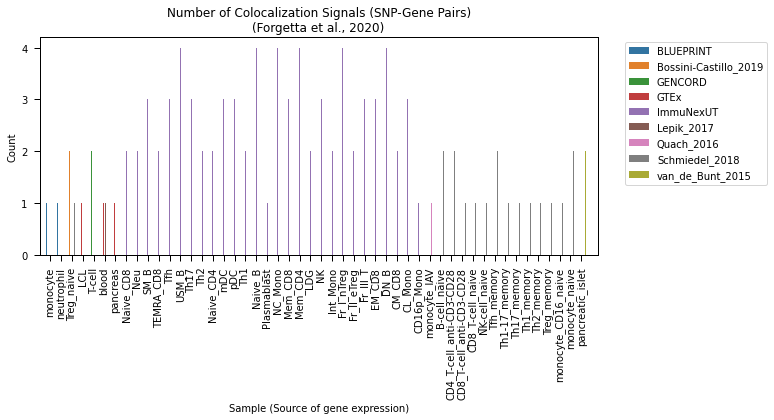

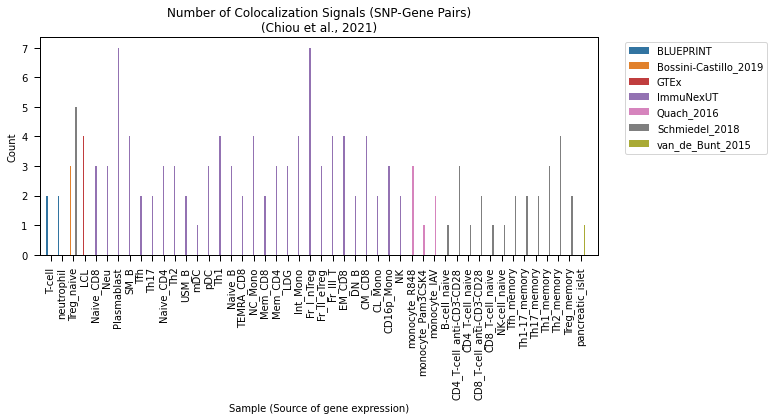

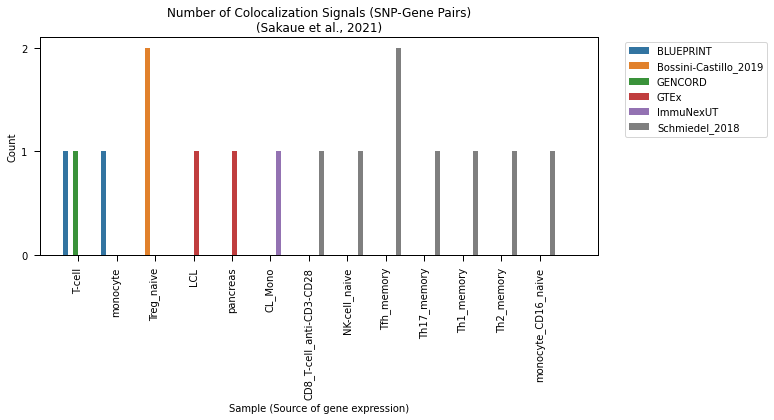

In [22]:
for gwas_source, gwas_summary in study_summary.groupby('gwas_source'):
        
    #sns.barplot(hue='eqtl', y='count', x='ge', data=study_summary)
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="count",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    # rotate the tick marks
    for x in g.get_xticklabels():
        x.set_rotation(90)
        

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']
    g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')
    g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))
    
    # expand the x limits
    ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)


#### Plotting all together

(-1.0, 13.5)

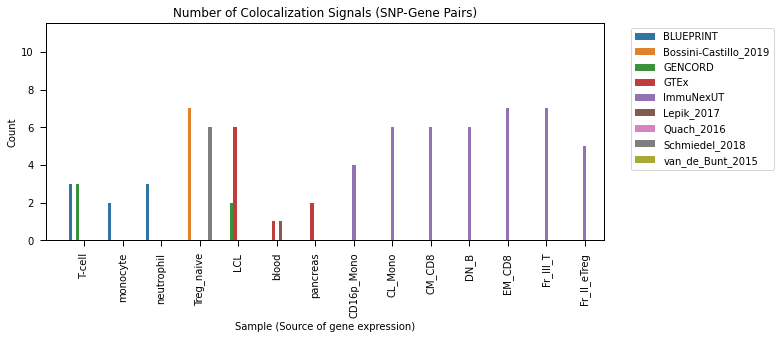

In [23]:
all_together = study_summary.groupby(['eqtl_source', 'ge_source'])['count'].sum().to_frame().reset_index()
#all_together.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,4))

# Draw a nested barplot by species and sex
g = sns.barplot(data=all_together,
            x="ge_source", y="count", hue='eqtl_source', palette=sns.color_palette(n_colors=len(all_together)), ax=ax)

# move the legend
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")

# rotate the tick marks
for x in g.get_xticklabels():
    x.set_rotation(90)

g.set_title('Number of Colocalization Signals (SNP-Gene Pairs)')
g.set_xlabel('Sample (Source of gene expression)')
g.set_ylabel('Count')
#g.set_yticks(list(range(0, max(gwas_summary['count']) + 1)))

# expand the x limits
ax.set_xlim(-1, gwas_summary.ge_source.nunique() + 0.5)

In [24]:
study_report_fn = os.path.join(outdir, 'coloc_report.tsv')
study_summary.to_csv(study_report_fn, sep='\t', index=False)

## Plotting the Number of Unique Genes per Colocalization Analysis

In [25]:
uniq_genes_per_sample = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).genename.nunique()
uniq_genes_per_sample = uniq_genes_per_sample.reset_index()

In [26]:
uniq_genes_per_sample

,gwas_source,eqtl_source,ge_source,genename
0,T1D_32005708,BLUEPRINT,monocyte,1
1,T1D_32005708,BLUEPRINT,neutrophil,1
2,T1D_32005708,Bossini-Castillo_2019,Treg_naive,2
3,T1D_32005708,GENCORD,LCL,2
4,T1D_32005708,GENCORD,T-cell,2
...,...,...,...,...
111,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2
112,T1D_34594039_GCST90018925,Schmiedel_2018,Th17_memory,1
113,T1D_34594039_GCST90018925,Schmiedel_2018,Th1_memory,1
114,T1D_34594039_GCST90018925,Schmiedel_2018,Th2_memory,1


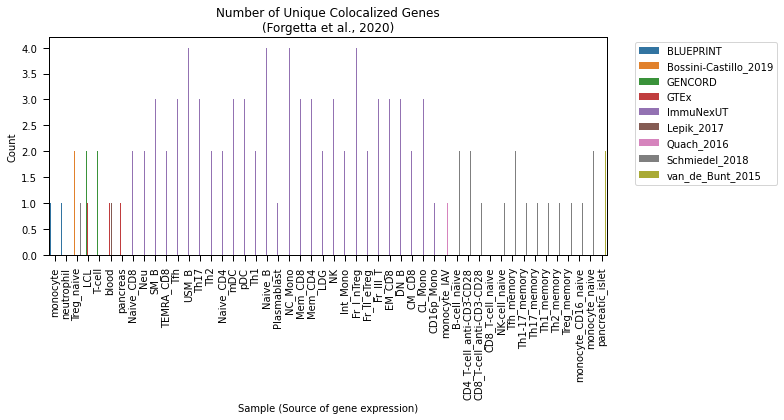

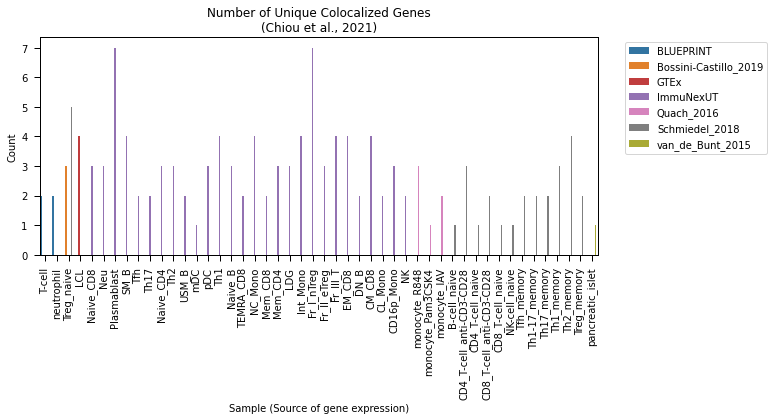

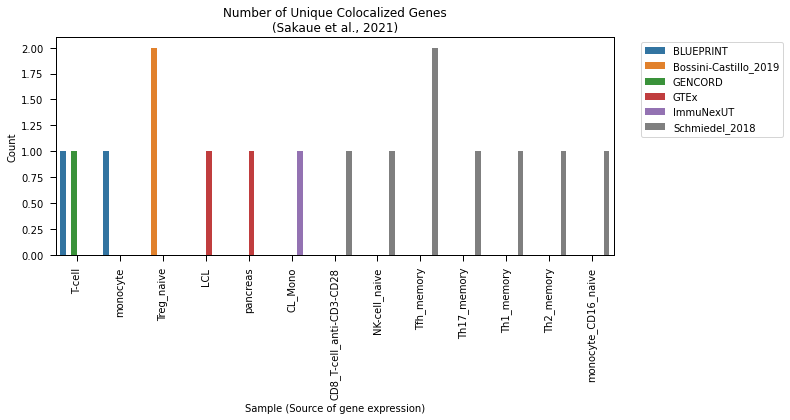

In [27]:
for gwas_source, gwas_summary in uniq_genes_per_sample.groupby('gwas_source'):
        
    fig, ax = plt.subplots(figsize=(10,4))
    
    # Draw a nested barplot by species and sex
    gwas_summary.sort_values('eqtl_source', inplace=True)
    g = sns.barplot(data=gwas_summary,
                x="ge_source", y="genename",
                hue='eqtl_source', palette=eqtl_colors, ax=ax)

    # move the legend
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    

    for x in g.get_xticklabels():
        x.set_rotation(90)

    gwas_authorship = gwas_samplesheet.loc[gwas_source, 'authorship']    
    g.set_title('Number of Unique Colocalized Genes\n({})'.format(gwas_authorship))
    g.set_xlabel('Sample (Source of gene expression)')
    g.set_ylabel('Count')

In [28]:
# find the uniq snps
uniq_snps_per_samples = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source']).rsid.nunique().reset_index()

### Table for the number of unique genes and snps per colocalization analyses

In [29]:
# concat the two tables
uniq_summary = uniq_genes_per_sample.merge(uniq_snps_per_samples)
uniq_summary.columns = ['gwas', 'eqtl', 'ge', 'Unique # Genes', 'Unique # SNPs']

In [30]:
pd.set_option('display.max_rows', 100) 
display(uniq_summary.sort_values(['gwas', 'Unique # SNPs'], ascending=False))
pd.set_option('display.max_rows', 20) 

,gwas,eqtl,ge,Unique # Genes,Unique # SNPs
104,T1D_34594039_GCST90018925,Bossini-Castillo_2019,Treg_naive,2,2
111,T1D_34594039_GCST90018925,Schmiedel_2018,Tfh_memory,2,2
102,T1D_34594039_GCST90018925,BLUEPRINT,T-cell,1,1
103,T1D_34594039_GCST90018925,BLUEPRINT,monocyte,1,1
105,T1D_34594039_GCST90018925,GENCORD,T-cell,1,1
...,...,...,...,...,...
46,T1D_32005708,Schmiedel_2018,Th1_memory,1,1
47,T1D_32005708,Schmiedel_2018,Th2_memory,1,1
48,T1D_32005708,Schmiedel_2018,Treg_memory,1,1
49,T1D_32005708,Schmiedel_2018,Treg_naive,1,1


### Table for the number snps per gene

In [31]:
# find the uniq snps
uniq_snps_per_genes = t1d_data.groupby(['gwas_source', 'eqtl_source', 'ge_source', 'gene_id'])

In [32]:
uniq_snps_per_genes = uniq_snps_per_genes.rsid.nunique().reset_index()

In [33]:
uniq_snps_per_genes.sort_values('rsid', ascending=False)

,gwas_source,eqtl_source,ge_source,gene_id,rsid
17,T1D_32005708,ImmuNexUT,DN_B,ENSG00000111300,2
37,T1D_32005708,ImmuNexUT,Mem_CD4,ENSG00000198270,2
0,T1D_32005708,BLUEPRINT,monocyte,ENSG00000197728,1
166,T1D_34012112_Gaulton,ImmuNexUT,Naive_B,ENSG00000162927,1
167,T1D_34012112_Gaulton,ImmuNexUT,Naive_B,ENSG00000235772,1
...,...,...,...,...,...
93,T1D_32005708,Schmiedel_2018,NK-cell_naive,ENSG00000197728,1
94,T1D_32005708,Schmiedel_2018,Tfh_memory,ENSG00000213994,1
95,T1D_32005708,Schmiedel_2018,Tfh_memory,ENSG00000254827,1
96,T1D_32005708,Schmiedel_2018,Th1-17_memory,ENSG00000197728,1


## Summarizing the Unique Genes Combined Across all Colocalization Analyses

In [34]:
# construct a table of unique genes 
gene_uniq_summary = t1d_data.drop_duplicates(['gwas_source', 'eqtl_source', 'ge_source', 'genename']).genename.value_counts()
gene_uniq_summary = gene_uniq_summary.to_frame()
gene_uniq_summary.sort_values('genename', ascending=False, inplace=True)
gene_uniq_summary.columns = ['Number of Unique Colocalizations per Gene in ALL Studies']

print('There are {} unique genes in the whole dataset.'.format(gene_uniq_summary.shape[0]))

# display this table
pd.set_option('display.max_rows', gene_uniq_summary.shape[0]) 
display(gene_uniq_summary)
pd.set_option('display.max_rows', 20) 

There are 118 unique genes in the whole dataset.


,Number of Unique Colocalizations per Gene in ALL Studies
RPS26,37
DOK6,18
TMEM116,13
AC016747.1,6
PUS10,6
IL2RA,6
AC016747.2,4
TMPRSS3,4
GLIS3,4
LSM8,4


In [35]:
msg = 'The number of genes across all colocalization analyses is: {}'.format(gene_uniq_summary.shape[0])
print(msg)

The number of genes across all colocalization analyses is: 118


In [36]:
# save an enrichr file 
enrichr_fn = os.path.join(outdir, 'enrichr.input.txt')
with open(enrichr_fn, 'w') as fw:
    for x in sorted(gene_uniq_summary.index.tolist()):
        print(x, file=fw)
        print(x)

ABCG1
AC002543.1
AC008063.1
AC008063.2
AC010733.1
AC016747.1
AC016747.2
AC016747.3
AC027228.1
AC068254.1
AC091196.1
AC091563.1
ACTA2
ADAM1B
AKR1C4
AL096678.1
AL121787.1
AL132996.1
AL133370.1
AL133445.2
AL137186.1
AL137779.2
AL137856.1
AL157394.2
AL157395.1
AL157871.5
AL163932.1
AL354760.1
AL354977.2
AL355303.1
AL359317.1
AL513548.4
ALDH2
AP001625.2
ARMH2
ASB13
BACH2
BCL11A
BEGAIN
BTN2A2
BTN3A1
BTN3A2
C1QTNF6
C2CD2
C2orf74
CACHD1
DEGS2
DOCK7
DOK6
DPP4
DSCC1
DUSP22
ENSG00000273802
ENSG00000278705
FIGNL1
GABRR2
GLIS3
GMNN
GPLD1
GPN3
HIST1H1A
HIST1H1PS1
HIST1H2AE
HIST1H2BH
HIST1H3D
HIST1H4E
HUS1B
IL2RA
ITPR3
KCNQ1-AS1
LINC01031
LINC01550
LINC02285
LINC02320
LINC02356
LINC02561
LINC02648
LSM8
MAGI3
MAPKAPK5
MAPKAPK5-AS1
NAA25
NDUFV3
NONOP2
NPIPB15
PAPOLG
PEX13
PGM1
PHETA1
PKNOX1
PRDM15
PRKCQ
PRKCQ-AS1
PTPN22
PUS10
RBM17
REL
RFX3
RGS1
RN7SL130P
ROR1
RPL7AP60
RPS26
SAMD12
SLC16A1-AS1
SLC22A18AS
SPATA6L
ST7
SUOX
TCF7L2
TDP2
TMEM116
TMPRSS3
TNFRSF11B
TRIM61
UMODL1
WDR4
ZFP36L1


### Quick dive into COLOC for analyses

In [37]:
select_cells = ['Plasmablast', 'Fr_I_nTreg']
select_data = t1d_data.loc[(t1d_data.gwas_source == 'T1D_34012112_Gaulton') & 
             (t1d_data.eqtl_source == 'ImmuNexUT') &
             (t1d_data.ge_source.isin(select_cells))]

In [38]:
select_data.loc[select_data.ge_source == 'Fr_I_nTreg']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
142,chr9,4292083,rs10758593,9:4292083:G:A,SPATA6L,0.775475,374591,2.811760e-03,1.527113e-01,0.203818,0.018893,0.124426,0.014135,1.330000e-18,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000106686,chr9,4553386.0,4666674.0,-,gene,protein_coding,both
143,chr2,60406328,rs13035645,2:60406328:T:A,AC016747.3,0.894993,793651,3.547170e-02,5.474464e-01,0.697347,0.003146,-0.087644,0.015296,1.010000e-08,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000273302,chr2,61427114.0,61427904.0,+,gene,sense_intronic,both
144,chr7,117462031,rs177069,7:117462031:A:G,AC002543.1,0.777563,585655,2.386220e-01,8.590260e-01,-0.435143,0.008709,0.117393,0.016117,3.250000e-13,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000235945,chr7,116513508.0,116516430.0,-,gene,processed_pseudogene,both
145,chr18,69866164,rs1790932,18:69866164:C:T,DOK6,0.892936,465109,1.591880e-06,3.157811e-04,-0.268596,0.010673,-0.102240,0.013995,2.760000e-13,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000206052,chr18,67068124.0,67516323.0,+,gene,protein_coding,both
146,chr14,100841366,rs34337125,14:100841366:G:A,BEGAIN,0.848185,253953,1.486410e-02,3.879238e-01,-0.224439,0.022822,-0.120547,0.014814,4.040000e-16,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000183092,chr14,101003484.0,101053750.0,-,gene,protein_coding,both
147,chr1,113285485,rs773560,1:113285485:G:A,MAGI3,0.979196,105264,1.936030e-02,4.354628e-01,0.184124,0.026659,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000081026,chr1,113933137.0,114228545.0,+,gene,protein_coding,both
148,chr21,42405613,rs9981624,21:42405613:G:C,TMPRSS3,0.908288,8767,9.030490e-11,4.013683e-08,0.710931,0.002507,0.147044,0.014822,3.390000e-23,T1D_34012112_Gaulton,ImmuNexUT,Fr_I_nTreg,ENSG00000160183,chr21,43791946.0,43816955.0,-,gene,protein_coding,both


In [39]:
select_data.loc[select_data.ge_source == 'Plasmablast']

,chr,pos,rsid,varid,genename,ppH4,sg_dist,eqtl_pval,eqtl_fdr,eqtl_slope,eqtl_slope_se,gwas_slope,gwas_slope_se,gwas_pval,gwas_source,eqtl_source,ge_source,gene_id,chrom,start,end,strand,type,detailed-type,_merge
179,chr1,63657608,rs11208260,1:63657608:G:A,PGM1,0.855703,64332,1.720090e-08,2.605504e-06,-0.308641,0.010007,0.111083,0.017211,1.090000e-10,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000079739,chr1,64059082.0,64125916.0,+,gene,protein_coding,both
180,chr2,60406328,rs13035645,2:60406328:T:A,PAPOLG,0.911215,349902,5.009830e-02,5.144423e-01,0.281216,0.022450,-0.087644,0.015296,1.010000e-08,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000115421,chr2,60983388.0,61029221.0,+,gene,protein_coding,both
181,chr22,37185445,rs229527,22:37185445:C:A,C1QTNF6,0.795971,13940,6.898180e-23,4.903488e-20,-0.588069,0.001953,0.104077,0.014138,1.820000e-13,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000133466,chr22,37576206.0,37595425.0,-,gene,protein_coding,both
182,chr9,4290823,rs6476839,9:4290823:A:T,RFX3,0.791872,764819,1.877290e-04,1.147042e-02,0.211862,0.017420,0.123270,0.014153,3.040000e-18,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000080298,chr9,3218297.0,3526004.0,-,gene,protein_coding,both
183,chr12,112412095,rs7300285,12:112412095:G:A,TMEM116,0.973973,398910,8.866680e-04,4.142134e-02,0.356715,0.008699,-0.126231,0.014906,2.480000e-17,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000198270,chr12,112369086.0,112450989.0,-,gene,protein_coding,both
184,chr1,113285485,rs773560,1:113285485:G:A,SLC16A1-AS1,0.972030,329070,1.377070e-03,5.862208e-02,0.181735,0.027376,0.168861,0.015663,4.230000e-27,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000226419,chr1,113499037.0,113589677.0,+,gene,antisense,both
185,chr21,42415901,rs80054410,21:42415901:T:C,UMODL1,0.881957,352942,1.406260e-01,7.162503e-01,0.245636,0.027948,0.140279,0.014471,3.200000e-22,T1D_34012112_Gaulton,ImmuNexUT,Plasmablast,ENSG00000177398,chr21,43483068.0,43563563.0,+,gene,protein_coding,both


## Saving genes for excel analysis 

In [40]:
# find the unique SNPs
uniq_snps_by_cells = t1d_data.groupby('ge_source').varid.nunique()
uniq_snps_by_cells = uniq_snps_by_cells.to_frame()

#find the unique genes 
uniq_genes_by_cells = t1d_data.groupby('ge_source').gene_id.nunique()
uniq_genes_by_cells = uniq_genes_by_cells.to_frame()

# merge
uniq_counts_by_cells = pd.merge(uniq_snps_by_cells, uniq_genes_by_cells, left_index=True, right_index=True)
uniq_counts_by_cells.columns = ['Number of Unique SNPs', 'Number of Unique Genes']
uniq_counts_by_cells.index.name = 'Cell Line'

In [41]:
# save the file
excel_analysis = os.path.join(outdir, 'Unique_Counts_By_Cell_Line.xlsx')
uniq_counts_by_cells.to_excel(excel_analysis, sheet_name='colocalization')

In [42]:
excel_analysis

'results/main/coloc/summary/Unique_Counts_By_Cell_Line.xlsx'

#### Write the gene list as well

In [43]:
gh_list = t1d_data.gene_id.unique()
gh_fn = os.path.join(outdir, 'gene_list.txt')
with open(gh_fn, 'w') as fw:
    for x in gh_list:
        fw.write('{}\n'.format(x))

In [126]:
gh_fn

'results/main/coloc/summary/gene_list.txt'

#### Get the unique genes per cell type 

In [44]:
genes_by_cell = t1d_data[['ge_source', 'gene_id']].drop_duplicates()
genes_by_cell.sort_values(['ge_source', 'gene_id'], inplace=True)
genes_by_cell['source'] = 'colocalization'
genes_by_cell.columns = ['cline', 'geneid', 'source']
fn = os.path.join(outdir, 'genes_by_cell.xlsx')
genes_by_cell.to_excel(fn, index=False)

In [45]:
genes_by_cell

,cline,geneid,source
89,B-cell_naive,ENSG00000197728,colocalization
90,B-cell_naive,ENSG00000237943,colocalization
215,B-cell_naive,ENSG00000258837,colocalization
121,CD16p_Mono,ENSG00000004866,colocalization
11,CD16p_Mono,ENSG00000139531,colocalization
...,...,...,...
10,pancreas,ENSG00000197728,colocalization
251,pancreas,ENSG00000285571,colocalization
107,pancreatic_islet,ENSG00000197728,colocalization
108,pancreatic_islet,ENSG00000198610,colocalization


## Make a figure of uniq SNPs and Genes per cell

In [65]:
to_higher = {'B-cells': ['DN_B', 'Naive_B', 'Plasmablast', 'SM_B', 'USM_B', 'B-cell_naive', 'LCL'],
             'CD4 T-cells': ['Mem_CD4', 'Naive_CD4', 'CD4_T-cell_anti-CD3-CD28', 'CD4_T-cell_naive',
                            'Tfh_memory', 'Th1-17_memory', 'Th17_memory', 'Th1_memory', 'Th2_memory',
                            'Tfh', 'Th1', 'Th17', 'Th2', 'Fr_III_T', 'Fr_II_eTreg', 'Fr_I_nTreg',
                            'Treg_memory', 'Treg_naive', 'T-cell'],
             'CD8 T-cells': ['CM_CD8','EM_CD8', 'Mem_CD8', 'Naive_CD8', 'CD8_T-cell_anti-CD3-CD28',
                            'CD8_T-cell_naive', 'TEMRA_CD8'],
             'Monocytes': ['monocyte', 'CD16p_Mono', 'CL_Mono', 'NC_Mono', 'monocyte_IAV', 'Int_Mono',
                           'monocyte_Pam3CSK4', 'monocyte_R848', 'monocyte_CD16_naive', 'monocyte_naive'],
             'NK cells': ['NK', 'NK-cell_naive']}

In [66]:
color_fn = 'results/refs/dice_colors/colors.revised.t1d-project.tsv'
colors = pd.read_table(color_fn)
cline_pubnames = {'CD4_T-cell_naive': 'CD4 T-cells', 'CD8_T-cell_naive': 'CD8 T-cells',
                  'monocyte_naive': 'Monocytes', 'B-cell_naive': 'B-cells', 'NK-cell_naive': 'NK cells'}
colors_dict = {sr.studyname: sr.hex for i, sr in colors.iterrows()}

In [67]:
tdata = []
for main_cell, sub_cells in to_higher.items(): 
    tdf = t1d_data.loc[t1d_data.ge_source.isin(sub_cells)]
    
    num_ge = tdf.gene_id.nunique()
    num_snps = tdf.rsid.nunique()

    tdata.append([main_cell, num_ge, num_snps])

In [68]:
uniq_counts_by_cells = pd.DataFrame(tdata)

In [71]:
uniq_counts_by_cells.columns = ['pubnames', 'Number of Unique Genes', 'Number of Unique SNPs']

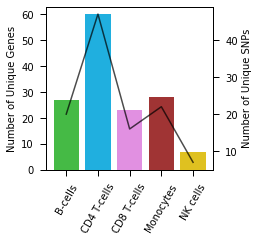

In [118]:
fig, ax = plt.subplots(figsize=(3,3))

sns.barplot(x='pubnames', y='Number of Unique Genes', palette=colors_dict, data=uniq_counts_by_cells, dodge=False)

ax.set_xlabel('')
ax.set_xticklabels(uniq_counts_by_cells['pubnames'], rotation = 60)

ax2 = ax.twinx()
sns.lineplot(x='pubnames', y='Number of Unique SNPs', data=uniq_counts_by_cells, color='#000000B3', ax=ax2)

sgl_summary_fn = os.path.join(outdir, 'sgs_coloc_with_sig_gwas_summary.svg')
fig.savefig(sgl_summary_fn)

## Characterizing SNPs within an SG

In [81]:
from biolib import liftover as liftover_utility
from liftover import get_lifter
lift_converter = get_lifter('hg38', 'hg19')

In [79]:
#loading Vu et al 2022 chromHMM annotations 
chromhmm = pd.read_table('results/refs/chromHMM/vu_et_al_2022/hg38lift_genome_100_segments.bed.gz', 
                         header=None)
chromhmm_pbt = pbt.BedTool.from_dataframe(chromhmm)

In [95]:
snps = t1d_data[['chr', 'pos']].drop_duplicates()
cords = []
for i, sr in snps.iterrows():
    new_cord = lift_converter[sr.chr][sr.pos][0]
    new_cord = [new_cord[0], new_cord[1] - 1, new_cord[1]]
    cords.append(new_cord)
snps_grch37 = pd.DataFrame(cords)
coloc_pbt = pbt.BedTool.from_dataframe(snps_grch37)

In [96]:
coloc_chromhmm = coloc_pbt.intersect(chromhmm_pbt, loj=True, wa=True)
coloc_chromhmm = coloc_chromhmm.to_dataframe()
coloc_chromhmm.columns = ['chr', 'start', 'end', 'chr2', 'chmm_start', 'chmm_end', 'state']

# extract the statename without the id number
def split_chromhmm(x):
    s = x.split('_')
    if len(s) > 1:
        return(s[1])
    else:
        return('None')
coloc_chromhmm['state_name'] = coloc_chromhmm.state.map(split_chromhmm)

# add the major state which removes the subtypes
coloc_chromhmm['major_state'] = coloc_chromhmm.state_name.str.replace('[0-9]+', '')

/mnt/hpcscratch/jreyna//ipykernel_14973/3785058445.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  coloc_chromhmm['major_state'] = coloc_chromhmm.state_name.str.replace('[0-9]+', '')


In [123]:
coloc_chromhmm[['chr', 'start']].drop_duplicates().shape

(73, 2)

In [99]:
state_dict = {'Quies': 'Quiescent',
             'ReprPC': 'Repressor',
             'GapArtf': 'No signal, unmappable',
             'Acet': 'Acetylation',
             'TxWk': 'Weak transcription',
             'EnhWk': 'Weak enhancer',
             'None': 'No overlap',
             'Tx': 'Transcription',
             'EnhA': 'Enhancer',
             'TxEx': 'Transcription & Exons',
             'HET': 'H3K9me3 & LTR repeats',
             'TxEnh': 'Transcription & Enhancers',
             'BivProm': 'Bivalent Promoters',
             'znf': 'Zinc Finger',
             'PromF': 'Downstream Promoter',
             'DNase': 'DNase',
             'TSS': 'TSS'}

state_colors = {'Quies': 'grey',
             'ReprPC': 'grey',
             'GapArtf': 'grey',
             'Acet': 'grey',
             'None': 'grey',
             'HET': 'grey',
             'EnhWk': 'lightYellow',
             'EnhA': 'yellow',
             'TxWk': 'lightGreen',
             'Tx': 'darkgreen',
             'TxEx': 'darkgreen',
             'TxEnh': 'darkgreen',
             'DNase': 'blue',
             'znf': 'blue', 
             'BivProm': 'red',
             'PromF': 'red',
             'TSS': 'red'}

fm_state_cnts = coloc_chromhmm.major_state.value_counts()
fm_state_cnts = fm_state_cnts.to_frame()
fm_state_cnts = fm_state_cnts.reset_index()
fm_state_cnts.columns = ['major_state', 'counts']

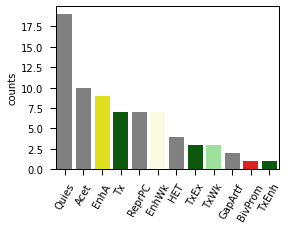

In [122]:
# Ploting the distribution of ALL Fine-mapped SNPs
fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(x='major_state', y='counts', data=fm_state_cnts, hue='major_state', palette=state_colors, dodge=False)

ax.set_xlabel('');
ax.set_xticklabels(fm_state_cnts['major_state'], rotation = 60);

# ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(1.5, 0.9),
#           fancybox=True, shadow=False)
ax.legend_.set_visible(False)

chromhmm_summary_fn = os.path.join(outdir, 'sg_coloc_snps_characterized_chromhmm.svg')
fig.savefig(chromhmm_summary_fn)

chromhmm_summary_fn = os.path.join(outdir, 'sg_coloc_snps_characterized_chromhmm.png')
fig.savefig(chromhmm_summary_fn, bbox_inches='tight', dpi=600)

## Save a unique list of SNPs within an SG

In [124]:
gwas_grps = t1d_data.groupby('gwas_source')
for gwas_source, gwas_df in gwas_grps:
    
    gwas_df['sid'] = t1d_data['varid'].str.replace(':[ACGT]:.*$', '')
    uniq_sids = gwas_df.sid.drop_duplicates().sort_values()
    uniq_sids = uniq_sids.str.replace(':', '-').str.replace('chr', '')
    
    fn = os.path.join(outdir, 'coloc_sgs.{}.tsv'.format(gwas_source))
    uniq_sids.to_csv(fn, header=False, index=False)

/mnt/hpcscratch/jreyna//ipykernel_14973/112585332.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  gwas_df['sid'] = t1d_data['varid'].str.replace(':[ACGT]:.*$', '')
/mnt/hpcscratch/jreyna//ipykernel_14973/112585332.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  gwas_df['sid'] = t1d_data['varid'].str.replace(':[ACGT]:.*$', '')
/mnt/hpcscratch/jreyna//ipykernel_14973/112585332.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  gwas_df['sid'] = t1d_data['varid'].str.replace(':[ACGT]:.*$', '')


In [127]:
uniq_sids

247    10-112994312
255      11-2159830
259      11-2160994
251      6-26482820
252      6-27287188
245      6-90279406
250      6-90304310
Name: sid, dtype: object

## Drawing Density of Distances between SNP and Genes Pairs 

In [ ]:
t = t1d_data.loc[t1d_data['eqtl_source'] == 'Schmiedel_2018']

In [ ]:
fig, ax = plt.subplots()
sns.histplot(t['sg_dist'], stat='count')

fig, ax = plt.subplots()
sns.histplot(t1d_data['sg_dist'], bins=50, stat='count')

fig, ax = plt.subplots()
sns.histplot(t1d_data['sg_dist'], stat='probability')

In [ ]:
t1d_data['sg_dist'].describe()

This is very important to note, about 60% of SNP-Gene Pairs are 400kb apart. This will severly limit the amount of overlapping loops.

## Drawing CorrPlots between GWAS p-values, eQTL p-values and Coloc PP4

In [ ]:
corr_data = t1d_data[['gwas_pval', 'eqtl_pval', 'eqtl_fdr', 'ppH4', 'sg_dist']]
corr_data.columns = ['GWAS P-value', 'eQTL P-value', 'eQTL FDR', 'COLOC PP4', 'SNP-Gene Distance']

In [ ]:
sns.pairplot(corr_data)

I thought I would see some kind of non-random relationship between GWAS/PP4 and eQTL/PP4. There is some filtering for significant GWAS and PP4 but I thought this relationship would still folder even after this. Not sure what to make of it as of right now. 

I talked with Sourya and I'm going to make a joint plot which is actually a heatmap with -log(GWAS) v. -log(eQTL) v. PP4.

In [ ]:
corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='-log10(GWAS P-value)',
                y='-log10(eQTL P-value)',
                hue='COLOC PP4',
                data=corr_data)
ax.set_xlim(0, 50)

In [ ]:
corr_data.loc[:, '-log10(GWAS P-value)'] = -np.log10(corr_data['GWAS P-value'])
corr_data.loc[:, '-log10(eQTL P-value)'] = -np.log10(corr_data['eQTL P-value'])


fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x='-log10(GWAS P-value)',
                y='-log10(eQTL P-value)',
                hue='COLOC PP4',
                data=corr_data)
ax.set_xlim(0, 30)
ax.set_ylim(0, 10)

In [ ]:
corr_data['GWAS P-value'].describe()

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

xlabel = '-log10(GWAS P-value)'
ylabel = '-log10(eQTL P-value)'
zlabel = 'COLOC PP4'


x = corr_data[xlabel]
y = corr_data[ylabel]
z = corr_data[zlabel]

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

ax.scatter(x, y, z)

ax.set_xlim(0, 50)
ax.set_ylim(0, 50)

plt.show()

## Make a circos plot

## Making the final table for poster: GWAS/eQTL/GE with genelist 

In [ ]:
final = t1d_data.sort_values(['gwas_source', 'eqtl_source', 'ge_source'])
final = final.groupby(['gwas_source', 'eqtl_source', 'ge_source'])
final = final.genename.unique()
final = final.to_frame().reset_index()
final.sort_values(['eqtl_source', 'ge_source'], inplace=True)
final = final.pivot(index='gwas_source', columns=['eqtl_source', 'ge_source'])
def genelist_to_str(x):
    
    if type(x) == float:
        return('None')
    else:
        l = sorted(x)
        l = ', '.join(l)
        l += '\nTotal Genes: ({})'.format(len(x))
        return(l)

final = final.applymap(genelist_to_str)
fn = os.path.join(outdir, 'poster-table.gwas.eqtl.ge.with_genelist.xlsx')
final.to_excel(fn)

## Making the final table for poster: GWAS/eQTL with genelist 

In [ ]:
gencode_gene_types = ['protein_coding', 'IG_V_gene', 'IG_C_gene',
                         'IG_J_gene', 'TR_C_gene', 'TR_J_gene',
                         'TR_V_gene', 'TR_D_gene', 'IG_D_gene']

In [ ]:
final_short = t1d_data.sort_values(['gwas_source', 'eqtl_source'])
final_short = final_short.loc[final_short['detailed-type'].isin(gencode_gene_types)]
final_short = final_short.groupby(['gwas_source', 'eqtl_source'])
final_short = final_short.genename.unique()
final_short = final_short.to_frame().reset_index()

final_short.sort_values(['eqtl_source'], inplace=True)
final_short = final_short.pivot(index='gwas_source', columns=['eqtl_source'])
final_short = final_short.applymap(genelist_to_str)

In [ ]:
final_short

In [ ]:
def cell_list_to_str(x):
    
    if type(x) == float:
        return('None')
    else:
        l = sorted(x)
        l = ', '.join(l)
        return(l)


In [ ]:
cell_lists = t1d_data[['eqtl_source', 'ge_source']].groupby('eqtl_source').ge_source.unique()
cell_lists = cell_lists.apply(cell_list_to_str)
final_short.loc['cell_lines', :] = cell_lists.tolist()

In [ ]:
final_short

In [ ]:
fn = os.path.join(outdir, 'poster-table.gwas.eqtl.short.with_genelist.xlsx')
final_short.to_excel(fn)

## Differentiating GWAS only from GWAS + eQTL Based Results

In [ ]:
num_both_driven = t1d_data.loc[t1d_data['eqtl_fdr'] < 0.05].shape[0]
num_gwas_driven = t1d_data.loc[t1d_data['eqtl_fdr'] > 0.05].shape[0]
driven_df = pd.DataFrame([['GWAS & eQTL', num_both_driven], ['GWAS Only', num_gwas_driven]])
driven_df.columns = ['Sig. Values', 'Count']

In [ ]:
driven_df

In [ ]:
fig, ax = plt.subplots(figsize=(3,4))
sns.barplot('Sig. Values', 'Count', data=driven_df, ax=ax)

## Showing a Colocalization Plots for Important Gene

In [ ]:
t1d_data.loc[t1d_data.genename == 'IL2RA']

In [ ]:
coloc_values = 'results/main/2021_Nikhil_eQTL/Results/ImmuNexUT/T1D_34012112_Gaulton/ImmuNexUT/SM_B/chr10_5617749_6617749/merged_SNPs_GWAS_input_colocalization.txt'

In [ ]:
tdf = pd.read_table(coloc_values)
tdf = tdf.loc[tdf.geneName.str.match('ENSG00000134460')]

In [ ]:
tdf['hue'] = 'Non-Coloc'
tdf.loc[tdf.pos == 6068912, 'hue'] = 'Coloc (PP4>0.75)'

In [ ]:
tdf['-log10(eqtl_pval)'] = -1 * np.log10(tdf['pvalue'])
tdf['-log10(gwas_pval)'] = -1 * np.log10(tdf['pval_nominal'])

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(13,4.75), gridspec_kw={'hspace': 0.1})
sns.scatterplot('pos', '-log(eqtl_pval)', hue='hue', data=tdf, ax=axes[0])

# plot the GWAS scatterplot
sns.scatterplot('pos', '-log(gwas_pval)', hue='hue', data=tdf, ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('$-log10(GWAS\,Pval)$')
axes[0].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off

# move the legend
axes[0].legend(bbox_to_anchor=(0.6,1), loc="upper left")

# plot the eQTL scatterplot
axes[1].set_xlabel('Chr6')
axes[1].set_ylabel('$-log10(eQTL\,Pval)$')
axes[1].set_xticklabels(['A', '6Mb', '6.1Mb', '6.2Mb', '6.3Mb', '6.4Mb'])

axes[1].legend_.set_visible(False)

coloc_png = os.path.join(outdir, 'coloc-example.IL2RA.png')
fig.savefig(coloc_png, bbox_inches='tight', dpi=600)

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(13,4.75), gridspec_kw={'hspace': 0.1})
sns.scatterplot('pos', '-log(eqtl_pval)', hue='hue', data=tdf, ax=axes[0])

# plot the GWAS scatterplot
sns.scatterplot('pos', '-log(gwas_pval)', hue='hue', data=tdf, ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('$-log10(GWAS\,Pval)$')
axes[0].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            labelbottom=False) # labels along the bottom edge are off

# move the legend
axes[0].legend(bbox_to_anchor=(0.8175,1), loc="upper left")

axes[0].set_xlim(6000000, 6140000)

# plot the eQTL scatterplot
axes[1].set_xlabel('Chr6')
axes[1].set_ylabel('$-log10(eQTL\,Pval)$')
#axes[1].set_xticklabels(['A', '6Mb', '6.1Mb', '6.2Mb', '6.3Mb', '6.4Mb'])

axes[1].legend_.set_visible(False)
axes[1].set_xlim(6000000, 6140000)
#axes[1].set_xticks([6000000, 6100000, 6180000])

coloc_png = os.path.join(outdir, 'coloc-example.IL2RA.png')
fig.savefig(coloc_png, bbox_inches='tight', dpi=600)